In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import asyncio
import time

from collections import defaultdict
warnings.filterwarnings("ignore")


In [74]:
# Tratamento de dados para o problema

df_dados = pd.read_excel("./sample_data/dados.xlsx")

quantidade_itens = df_dados['Item'].nunique()
quantidade_caixas = df_dados['Caixa Id'].nunique()

itens = df_dados['Item'].unique().tolist()
caixas = df_dados['Caixa Id'].unique().tolist()

pecas_por_caixa = df_dados.groupby('Caixa Id')['Peças'].sum()
pecas_por_item = df_dados.groupby('Item')['Peças'].sum()
pecas_por_item = pecas_por_item.to_dict()

df_dados['Quantidade Total Peças'] = df_dados['Caixa Id'].map(pecas_por_caixa)

df_dados = df_dados.groupby('Caixa Id').agg(list)

def obter_valores_unicos(valores):
  return valores[0] if valores else None

df_dados['Quantidade Total Peças'] = df_dados['Quantidade Total Peças'].apply(obter_valores_unicos)

df_dados = df_dados.sort_values(by='Quantidade Total Peças', ascending=False)

In [75]:
# Variáveis necessárias
np.random.seed(42)
capacidade_onda = 2000

In [76]:
def calcula_ondas_ativas(solucao):
  ondas_ativas = []
  for id, onda in solucao.items():
    caixas_ativas = [i for i, valor in enumerate(onda) if valor == 1]
    if len(caixas_ativas) >= 1:
      ondas_ativas.append(id)
  return ondas_ativas

In [77]:
# Função Objetivo
def calcula_fo(s):
  n_caixas = len(s)
  itens_distintos = 0

  for onda in s:
    itens_onda = set()
    for id_caixa in range(0, len(onda)):
      if onda[id_caixa] == 1:
        caixa = caixas[id_caixa]
        itens_caixa = df_dados.loc[caixa]['Item']
        itens_onda.update(itens_caixa)
    itens_distintos += len(itens_onda)
  return itens_distintos / quantidade_itens

In [78]:
def obter_alocacao_onda(onda):
  alocacao = [0]
  for id_caixa in range(0, quantidade_caixas):
    if onda[id_caixa] == 1:
      caixa = caixas[id_caixa]
      pecas_caixa = df_dados.loc[caixa]['Peças']
      alocacao.append(sum(pecas_caixa))
  return sum(alocacao)

In [79]:
def calcula_alocacao_ondas(solucao):
  alocacao = dict()
  for id, onda in solucao.items():
    valor_alocacao = obter_alocacao_onda(onda)
    alocacao[id] = capacidade_onda - valor_alocacao
  return alocacao

In [80]:
def define_matriz_solucao(solucao):
  ondas_ativas = calcula_ondas_ativas(solucao)
  z_kj = np.zeros((quantidade_itens, ondas_ativas[-1]+1))

  for id in ondas_ativas:
    onda = solucao[id]
    for id_caixa in range(0, quantidade_caixas):
      if onda[id_caixa] == 0:
        continue

      caixa = caixas[id_caixa]
      itens_caixa = df_dados.loc[caixa]['Item']
      for id_item in range(0, len(itens_caixa)):
        z_kj[id_item][id] = 1
  return z_kj

In [81]:
def swap(caixas_removidas, onda):
  for caixa in caixas_removidas:
    onda[caixa] = 1
  return onda

def seleciona_onda(id_i, solucao):
  n_ondas = list(solucao.keys())[-1]
  id_j = np.random.randint(0, n_ondas)
  while id_j == id_i:
    id_j = np.random.randint(0, n_ondas)
  return id_j

def seleciona_caixas(solucao, quantidade, numero_ondas):
  tentativas = 0

  while True:
    if tentativas >= numero_ondas:
      break

    id = np.random.randint(0, numero_ondas)
    onda = solucao[id]
    caixas_ativas = [i for i, valor in enumerate(onda) if valor == 1]

    if len(caixas_ativas) >= quantidade:
      return id, np.random.choice(caixas_ativas, size=quantidade, replace=False)

    tentativas += 1

  return 0, np.random.choice(caixas, size=quantidade, replace=False)

def desaloca_caixas(onda, caixas):
  for caixa in caixas:
    onda[caixa] = 0
  return onda

In [82]:
# Solução Inicial: Construtiva gulosa, seleciona as caixas com mais itens distintos e aloca em uma onda.
# Quando a onda estiver sem capacidade para mais itens, ativa nova onda
def gera_solucao_inicial():
  ondas = dict()
  onda = [0] * quantidade_caixas
  ondas[0] = onda

  capacidade_ondas = dict()
  capacidade_ondas[0] = capacidade_onda

  for caixa in caixas:
    id_caixa = caixas.index(caixa)
    pecas_caixa = df_dados.loc[caixa]['Peças']
    for id, onda in list(ondas.items()):
      demanda_onda = capacidade_ondas[id]

      demanda_temporaria = demanda_onda - sum(pecas_caixa)
      if demanda_temporaria < 0:
        if id == list(ondas.keys())[-1]:
          nova_onda = [0] * quantidade_caixas
          novo_id = id + 1
          nova_onda[novo_id] = 1
          ondas[novo_id] = nova_onda
          capacidade_ondas[novo_id] = capacidade_onda
          break
        continue

      onda[id_caixa] = 1
      ondas[id] = onda
      capacidade_ondas[id] = demanda_temporaria
      break
  return ondas, capacidade_ondas

In [83]:
# Vizinhança
def perturbacao_onda(solucao, n_vizinhanca, numero_ondas):
  try:
    resultado = seleciona_caixas(solucao, n_vizinhanca, numero_ondas)
    id, caixas_selecionadas = resultado

    onda = solucao[id]
    for id_caixa in caixas_selecionadas:
      onda[id_caixa] = 0

    solucao[id] = onda
    return id, solucao, caixas_selecionadas

  except:
    return 0, solucao, []


def define_vizinhos(solucao, n_vizinhanca, numero_ondas, capacidade_ondas):
  solucao_vizinha = solucao
  capacidade_vizinha = capacidade_ondas
  resultado = perturbacao_onda(solucao_vizinha, n_vizinhanca,numero_ondas)

  id_selecao, solucao_vizinha, caixas_restantes = resultado
  for id_caixa in caixas_restantes:
    caixa = caixas[id_caixa]
    pecas_caixa = df_dados.loc[caixa]['Peças']

    for id, onda in list(solucao_vizinha.items()):
      if id == id_selecao:
        continue

      demanda_onda = capacidade_vizinha[id]
      demanda_temporaria = demanda_onda - sum(pecas_caixa)

      if demanda_temporaria < 0:
        if id == list(solucao_vizinha.keys())[-1]:
          nova_onda = [0] * quantidade_caixas
          novo_id = id + 1
          nova_onda[novo_id] = 1
          solucao_vizinha[novo_id] = nova_onda
          capacidade_vizinha[novo_id] = capacidade_onda
          break
        continue

      onda[id_caixa] = 1
      solucao_vizinha[id] = onda
      capacidade_vizinha[id] = demanda_temporaria
      break
  return solucao_vizinha

In [84]:
async def gera_vizinho(solucao, vizinho):
  s = solucao.copy()
  try:
      solucao = await asyncio.wait_for(obter_opt(solucao, vizinho), timeout=300)
  except asyncio.TimeoutError:
     return s
  return solucao

def obter_opt(solucao, vizinho):
  numero_ondas = list(solucao.keys())[-1]

  resultado = seleciona_caixas(solucao, vizinho, numero_ondas)
  id_i, caixas_i = resultado

  id_j = id_i
  caixas_j = caixas_i

  while True:
    resultado = seleciona_caixas(solucao, vizinho, numero_ondas)
    id_j, caixas_j = resultado

    if id_j != id_i:
      break

  onda_i = solucao[id_i].copy()
  onda_j = solucao[id_j].copy()

  onda_i = desaloca_caixas(onda_i, caixas_i)
  onda_j = desaloca_caixas(onda_j, caixas_j)

  onda_i = swap(caixas_j, onda_i)
  onda_j = swap(caixas_i, onda_j)

  alocacao_j = obter_alocacao_onda(onda_j)
  alocacao_i = obter_alocacao_onda(onda_i)

  if alocacao_j <= capacidade_onda and alocacao_i <= capacidade_onda:
    solucao[id_i] = onda_i
    solucao[id_j] = onda_j
    return solucao

  onda = [0] * quantidade_caixas
  id = numero_ondas + 1

  for id_caixa in caixas_i:
    caixa = caixas[id_caixa]
    pecas_caixa = df_dados.loc[caixa]['Peças']
    qpecas = sum(pecas_caixa)

    if qpecas > capacidade_onda:
      print("Caixa acima do limite permitido. Ignorando...")
      break

    alocacao = obter_alocacao_onda(onda) + qpecas
    if alocacao > capacidade_onda:
      onda = [0] * quantidade_caixas
      id += 1

    onda[id_caixa] = 1
    solucao[id] = onda
  return solucao

In [85]:
# Busca Local
def busca_local(solucao_inicial, alocacao_ondas):
  solucao = solucao_inicial
  alocacao_ondas = calcula_alocacao_ondas(solucao)
  z_kj = define_matriz_solucao(solucao)

  parar_plato = 0

  vizinhos = []
  vizinho = 0

  fo = []

  while True:
    if vizinho >= quantidade_caixas:
      break

    numero_ondas = list(solucao_inicial.keys())[-1]
    solucao_vizinha = define_vizinhos(solucao, vizinho, numero_ondas, alocacao_ondas)
    vizinhos.append(solucao_vizinha)

    vizinho += 1

  atual = calcula_fo(z_kj)
  melhor = atual
  solucao_atual = solucao
  fo.append(atual)

  for solucao_vizinha in vizinhos:
    z_kj_vizinho = define_matriz_solucao(solucao_vizinha)
    fo_vizinho = calcula_fo(z_kj)

    if fo_vizinho <= melhor:
      parar_plato = parar_plato + 1 if fo_vizinho == melhor else 0
      melhor = fo_vizinho
      solucao = solucao_vizinha
      z_kj = z_kj_vizinho

    if melhor == atual and np.array_equal(z_kj_vizinho, z_kj) or parar_plato == 20:
      if parar_plato == 20: print('plato')
      break

  return solucao, fo

In [86]:
# VNS
async def VNS():
  solucao, alocacao_ondas = gera_solucao_inicial()
  vizinhancas = (quantidade_caixas // 2)
  vizinho = (quantidade_caixas // 4)

  fo_solucoes = []

  try:
    while vizinho <= vizinhancas:
      solucao_vizinha = await asyncio.wait_for(gera_vizinho(solucao, vizinho), timeout=300)
      alocacao_ondas_vizinha = calcula_alocacao_ondas(solucao_vizinha)

      resultado = busca_local(solucao_vizinha, alocacao_ondas_vizinha)

      solucao_busca_local, fo  = resultado
      fo_solucoes.append(fo)

      if len(fo_solucoes) > 1:
        id_remover = 0 if min(fo_solucoes[1]) < min(fo_solucoes[0]) else 1
        fo_solucoes.pop(id_remover)

      z_kj_vizinho = define_matriz_solucao(solucao_vizinha)
      z_kj_busca = define_matriz_solucao(solucao_busca_local)

      fo_vizinho = calcula_fo(z_kj_vizinho)
      fo_busca = calcula_fo(z_kj_busca)

      if fo_busca < fo_vizinho:
        solucao = solucao_busca_local
        alocacao_ondas = calcula_alocacao_ondas(solucao)
        vizinho = (quantidade_caixas // 4)
      else:
        vizinho += (quantidade_caixas // 4)
  except asyncio.TimeoutError:
    return solucao, fo_solucoes
  return solucao, fo_solucoes


In [87]:
def imprime_solucao(df_solucao):
  df_solucao.drop_duplicates(inplace=True)
  grouped_df = df_solucao.groupby('Onda')['Quantidade'].sum().reset_index()
  grouped_df = grouped_df.sort_values(by='Quantidade')

  cores = plt.cm.get_cmap('viridis', len(grouped_df))

  plt.figure(figsize=(10, 6))
  bars = plt.bar(grouped_df['Onda'], grouped_df['Quantidade'], color=cores(np.arange(len(grouped_df))))

  plt.xlabel('Onda')
  plt.ylabel('Quantidades')
  plt.title('Métrica de Ondas')
  plt.xticks(grouped_df['Onda'])

  sm = plt.cm.ScalarMappable(cmap=cores)
  sm.set_array([])
  cbar = plt.colorbar(sm)
  cbar.set_label('Quantidade')

  plt.tight_layout()
  plt.show()

In [88]:
def imprime_fo(fo):
  t = np.arange(0.0, len(fo), 1)

  plt.figure(figsize=(12,8))
  plt.plot(t, fo)
  plt.show()

In [89]:
def exportar_solucao(df_solucao):
  excel_file = './sample_data/ondas.xlsx'
  df_solucao.to_excel(excel_file, index=False)

  print(f"Matriz salva com sucesso em '{excel_file}'.")

FO encontrada: 0.09351753453772582


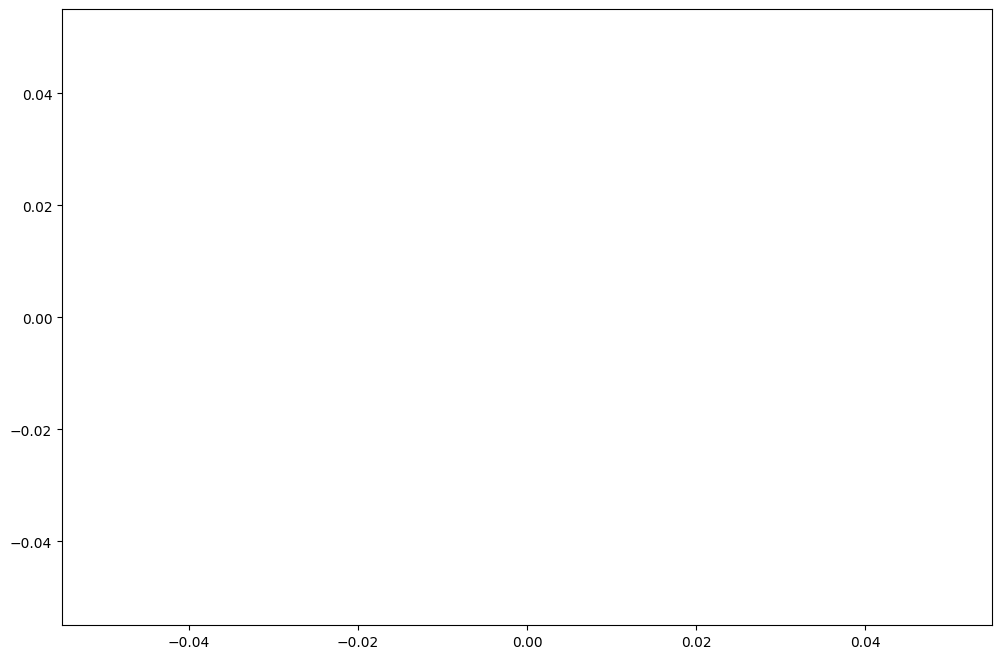

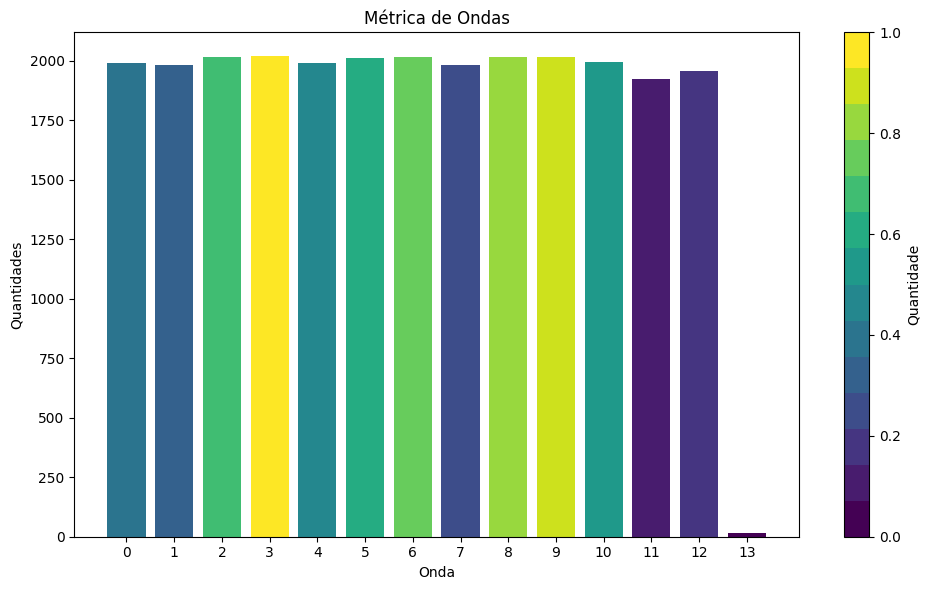

Matriz salva com sucesso em './sample_data/ondas.xlsx'.


In [90]:
async def main():
  vns = await VNS()
  solucao, fo = vns
  z_kj = define_matriz_solucao(solucao)
  fo_solucao = calcula_fo(z_kj)
  print(f"FO encontrada: {fo_solucao}")

  df_solucao = pd.DataFrame(columns=['Onda', 'Item', 'Quantidade'])
  for id, onda in solucao.items():
    for id_caixa in range(0, quantidade_caixas):
      if onda[id_caixa] == 0:
        continue

      caixa = caixas[id_caixa]

      itens_caixa = df_dados.loc[caixa]['Item']
      pecas_caixa = df_dados.loc[caixa]['Peças']
      for item, peca in zip(itens_caixa, pecas_caixa):
        row = {'Onda': id, 'Item': item, 'Quantidade': peca}
        row = pd.DataFrame([row])
        df_solucao = pd.concat([df_solucao, row], ignore_index=True)

  # imprime_fo(fo)
  imprime_solucao(df_solucao)
  exportar_solucao(df_solucao)

await main()